In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as scs
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
import datetime
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

In [2]:
start8 = datetime.date(2010, 6, 30)
end8 = datetime.date(2022, 7, 1)
ticker8 = "NFLX"

In [3]:
df = yf.download(ticker8, start=start8, end=end8, progress=False)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker8} data")

Downloaded 3022 rows and 6 columns of NFLX data


In [4]:
df8 = df.copy()

In [5]:
df8 = df8.resample('W').agg({'Open':'first', 'High':'max', 'Low': 'min', 
                             'Close':'last', 'Adj Close':'last'})

In [6]:
df8.drop(columns=["Open", "High", "Low", "Close"], inplace=True)
df8.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)
print(df8.tail())

             adj_close
Date                  
2022-06-05  198.979996
2022-06-12  182.940002
2022-06-19  175.509995
2022-06-26  190.850006
2022-07-03  174.869995


In [7]:
df8[df8['adj_close'].isnull()]

,adj_close
Date,


In [8]:
start8_str = (start8 + pd.Timedelta("5 days")).strftime("%B %Y")
end8_str = (end8 - pd.Timedelta("5 days")).strftime("%B %Y")

<Axes: title={'center': 'NFLX weekly adjusted close prices (July 2010 - June 2022)'}, xlabel='Date'>

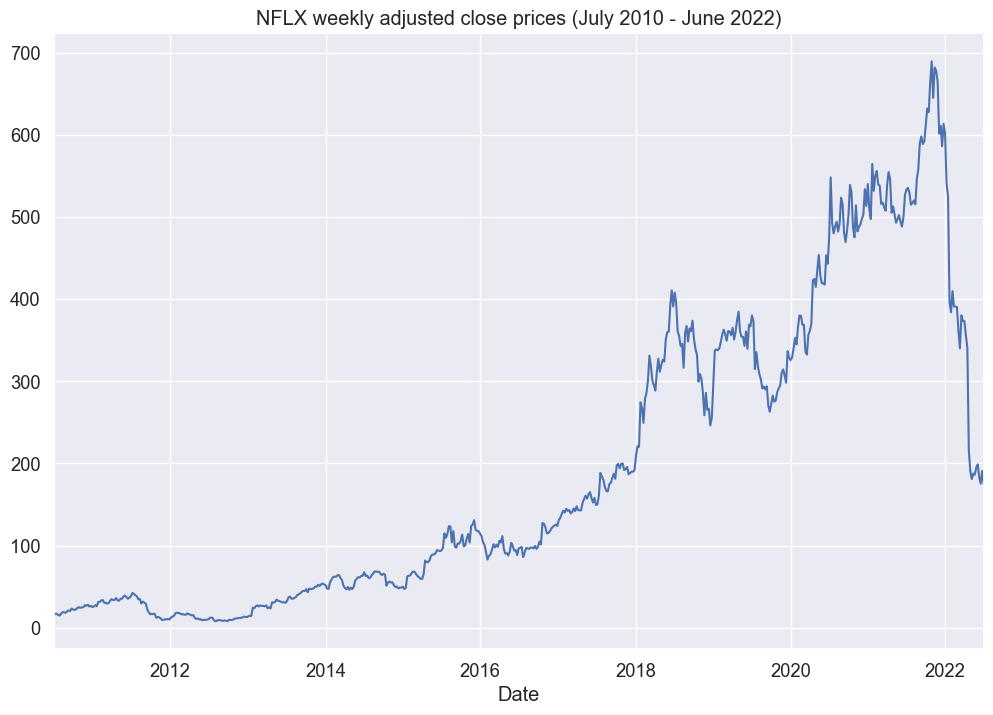

In [9]:
sns.set(font_scale=1.2)
df8['adj_close'].plot(figsize=(12, 8), title=f"{ticker8} weekly adjusted close prices ({start8_str} - {end8_str})")

In [10]:
df8['log_returns'] = np.log(df8['adj_close'] / df8['adj_close'].shift(1))
df8.dropna(axis='rows', how='any', inplace=True)

In [11]:
%%time

arima_model = ARIMA(df8['adj_close'], order=(3, 1, 2))

arima_fit1 = arima_model.fit()

arima_fit1.summary()

CPU times: total: 672 ms
Wall time: 1.43 s


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              adj_close   No. Observations:                  626
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -2572.130
Date:                Sun, 26 Feb 2023   AIC                           5156.261
Time:                        21:38:25   BIC                           5182.887
Sample:                    07-11-2010   HQIC                          5166.607
                         - 07-03-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2584      0.043     -5.949      0.000      -0.344      -0.173
ar.L2         -0.8846      0.036    -24.809      0.000      -0.954      -0.815
ar.L3          0.0968      0.037      2.592      0.010       0.024       0.170
ma.L1          0.2707      0.036      7.601      0.000       0.201       0.341
ma.L2          0.9182      0.034     26.963      0.000       0.851       0.985
sigma2       252.4253      6.239     40.460      0.000     240.197     264.653
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              8249.82
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):             114.56   Skew:                            -1.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
def arima_diagnostics(resids_, figsize=(15, 9), n_lags=40):
    '''
    Diagnoses the fit of an ARIMA model by examining its residuals.
    Returns a chart with with multiple plots
    '''
    # Creating placeholder subplots
    M = 2
    N = 2
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(M, N, figsize=figsize)

    r = resids_
    resids_ = (r - np.nanmean(r)) / np.nanstd(r)
    resids_nonmissing = resids_[~(np.isnan(resids_))]
    
    # Plotting residuals over time
    sns.lineplot(x=np.arange(len(resids_)), 
                 y=resids_, ax=ax1)
    ax1.set_title('Standardized residuals')

    # Plotting the distribution of residuals
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    
    sns.distplot(resids_nonmissing, hist=True, kde=True, 
                 norm_hist=True, ax=ax2)
    ax2.plot(r_range, norm_pdf, color='green', linewidth=2, label='N(0,1)')
    ax2.set_title('Distribution of standardized residuals')
    ax2.set_xlim(x_lim)
    ax2.legend()
        
    # Q-Q plot
    qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
    ## 's' is for standardized line to compare the plot with a normal distribution
    ax3.set_title('Q-Q plot')

    # ACF plot
    sm.graphics.tsa.plot_acf(resids_, lags=n_lags, ax=ax4, alpha=0.05)
    ax4.set_title('ACF plot')

    return fig

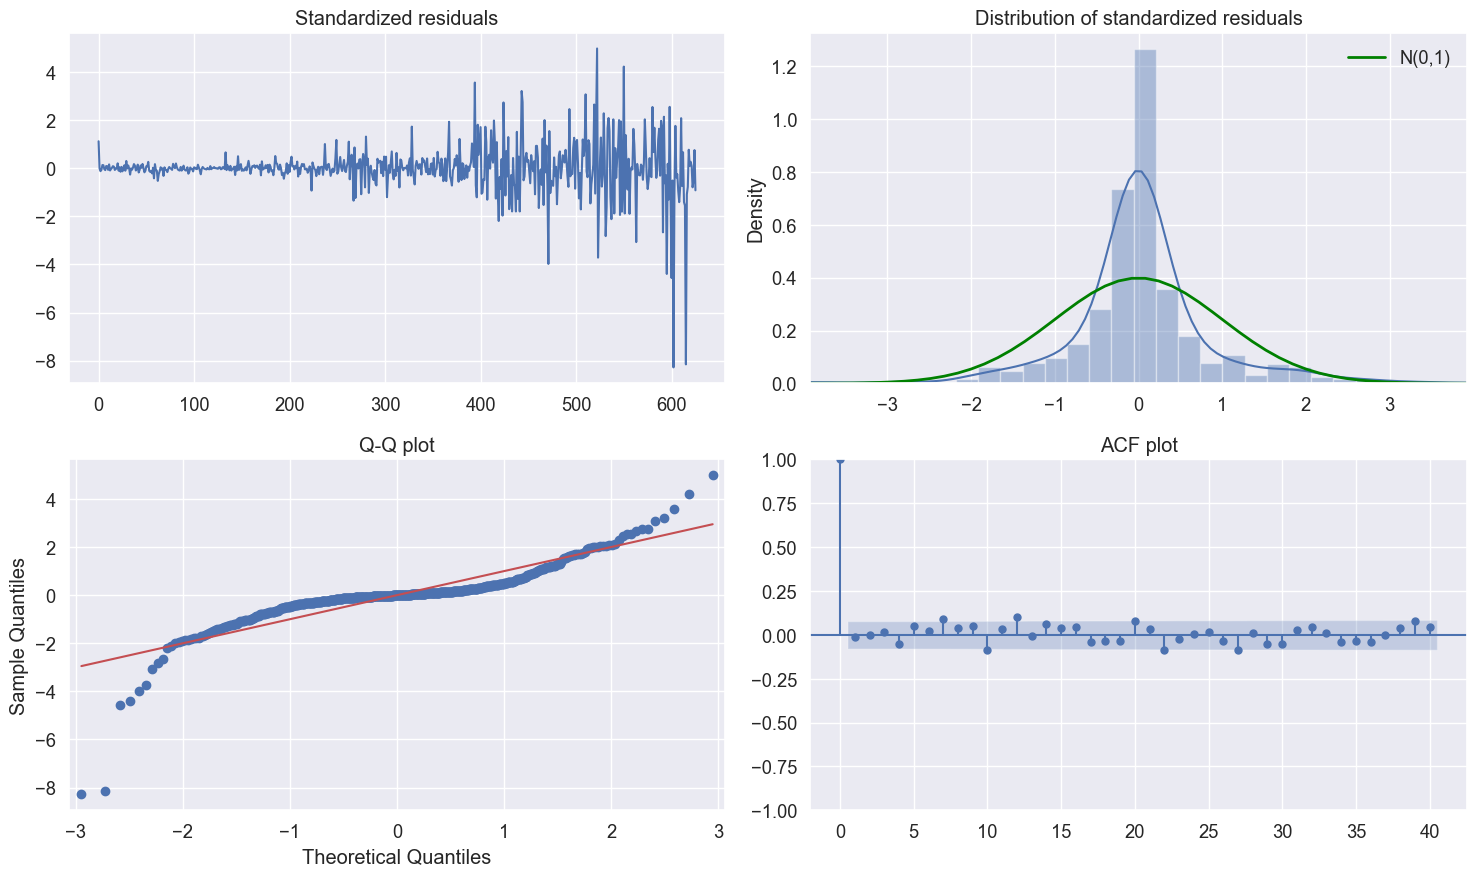

CPU times: total: 2.47 s
Wall time: 3.07 s


In [13]:
%%time
sns.set(font_scale=1.2)
arima_diagnostics(arima_fit1.resid)
plt.tight_layout()
plt.show();

In [14]:
## Running the Jarque-Bera test and interpreting its results

from statsmodels.stats.stattools import jarque_bera

jb_test_stat, pvalue, _, _ = jarque_bera(arima_fit1.resid)
print(f"Jarque-Bera statistic: {jb_test_stat:.2f} with p-value: {pvalue:.2f}")

if pvalue < 0.05:
    print("Our residuals are likely not normally distributed.")
else:
    print("Our residuals are likely normally distributed.")


Jarque-Bera statistic: 8230.07 with p-value: 0.00
Our residuals are likely not normally distributed.


In [15]:
%%time

import pmdarima as pm

## Fitting the model (This is the default setting)
arima_fit2 = pm.auto_arima(df8['adj_close'], error_action='ignore', 
                           suppress_warnings=True, seasonal=False)

CPU times: total: 578 ms
Wall time: 2.99 s


In [16]:
arima_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  626
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2582.510
Date:                Sun, 26 Feb 2023   AIC                           5167.021
Time:                        21:38:31   BIC                           5171.458
Sample:                    07-11-2010   HQIC                          5168.745
                         - 07-03-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       227.2767      3.999     56.839      0.000     219.440     235.114
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              9510.23
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):             121.60   Skew:                            -1.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
%%time

arima_fit3 = pm.auto_arima(df8['adj_close'], error_action='ignore', 
                           suppress_warnings=True, stepwise=False, 
                           approximation=False, seasonal=False)

arima_fit3.summary()

CPU times: total: 5.42 s
Wall time: 14 s


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  626
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -2570.746
Date:                Sun, 26 Feb 2023   AIC                           5155.491
Time:                        21:38:46   BIC                           5186.556
Sample:                    07-11-2010   HQIC                          5167.562
                         - 07-03-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.6935      1.629     -0.426      0.670      -3.885       2.498
ar.L1         -0.2999      0.043     -6.979      0.000      -0.384      -0.216
ar.L2         -0.9187      0.032    -28.590      0.000      -0.982      -0.856
ar.L3          0.0496      0.038      1.322      0.186      -0.024       0.123
ma.L1          0.2771      0.035      7.840      0.000       0.208       0.346
ma.L2          0.9402      0.031     29.872      0.000       0.879       1.002
sigma2       249.8412      6.512     38.365      0.000     237.078     262.605
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):              8803.06
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):             108.14   Skew:                            -1.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
start9 = datetime.date(2019, 6, 30)
end9 = datetime.date(2020, 7, 7)
ticker9 = ticker8

In [19]:
df = yf.download(ticker9, start=start9, end=end9, progress=False)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker9} data")

Downloaded 256 rows and 6 columns of NFLX data


In [20]:
df9 = df.copy()

In [21]:
df9 = df9.resample('W').agg({'Open':'first', 'High':'max', 'Low': 'min', 
                             'Close':'last', 'Adj Close':'last'})

In [22]:
df9.drop(columns=["Open", "High", "Low", "Close"], inplace=True)
df9.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)
print(df9.tail())

             adj_close
Date                  
2020-06-14  418.070007
2020-06-21  453.720001
2020-06-28  443.399994
2020-07-05  476.890015
2020-07-12  493.809998


In [23]:
df9[df9['adj_close'].isnull()]

,adj_close
Date,


In [24]:
n_fcast3 = len(df9)

In [25]:
%%time

arima_fcast3 = arima_fit3.predict(n_periods=n_fcast3, 
                                  return_conf_int=True, alpha=0.05)

CPU times: total: 15.6 ms
Wall time: 64.4 ms


In [26]:
%%time

arima_fcast3 = [pd.DataFrame(arima_fcast3[0], columns=['prediction']), 
                pd.DataFrame(arima_fcast3[1], columns=['lower_95', 
                                                       'upper_95'])]

arima_fcast3 = pd.concat(arima_fcast3, axis=1).set_index(df9.index)

ValueError: Length mismatch: Expected 108 rows, received array of length 54

AttributeError: 'list' object has no attribute 'prediction'

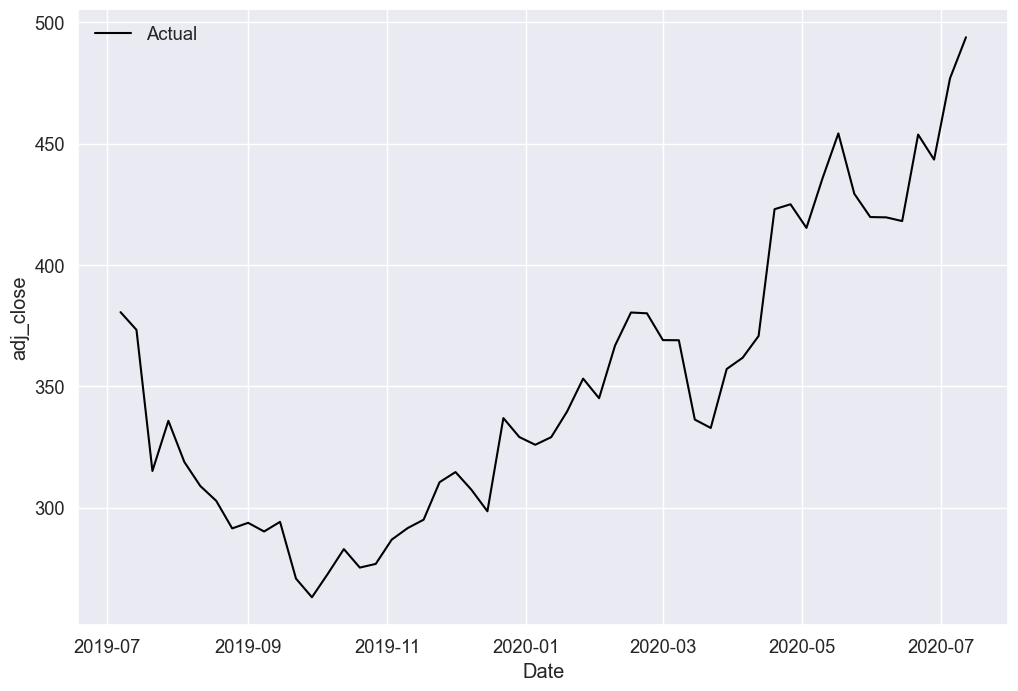

In [27]:
%%time

## Plotting the results for both models

fig, ax = plt.subplots(1, figsize=(12, 8))

ax = sns.lineplot(data=df9['adj_close'], color='black', label='Actual')

ax.plot(arima_fcast3.prediction, color='red', label='ARIMA(2, 1, 2)')

ax.fill_between(arima_fcast3.index, arima_fcast3.lower_95, 
                arima_fcast3.upper_95, alpha=0.2, 
                facecolor='red')

ax.set(title=f"{ticker8} stock price - actual vs. predicted", xlabel='Date',
       ylabel='Adjusted close price (US$)')
ax.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/ch3_im25.png')
plt.show()
